In [47]:
import wikipediaapi as wiki
from tqdm import tqdm
import pymorphy2
import numpy as np
import nltk
import string
from gensim.models import *
from gensim import corpora
from gensim import similarities
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

In [16]:
wiki_wiki = wiki.Wikipedia('ru')
page_py_1 = wiki_wiki.page('Категория:Кухни народов мира')
page_py_2 = wiki_wiki.page('Категория:Кухни по странам')

## Получаем список кухонь

In [17]:
def get_categorymembers(categorymembers, level=0, max_level=0):
        return categorymembers.values()

cuisines_1 = get_categorymembers(page_py_1.categorymembers)
cuisines_2 = get_categorymembers(page_py_2.categorymembers)

cuisines_list = []
for page in cuisines_1:
    if 'Категория:' in page.title:
        cuisines_list.append(page.title)

for page in cuisines_2:
    if 'Категория:' in page.title:
        cuisines_list.append(page.title)

In [18]:
cuisines_list = list(set(cuisines_list))

In [19]:
cuisines_list[:5]

['Категория:Болгарская кухня',
 'Категория:Иорданская кухня',
 'Категория:Хорватская кухня',
 'Категория:Итальянская кухня',
 'Категория:Хакасская кухня']

## Пробегаем по страницам и записываем summary статей по категориям кухонь

In [20]:
f = open('cuisines.txt', 'w')

names_of_cuis = []

for cuisine in tqdm(cuisines_list):
    dishes = get_categorymembers(wiki_wiki.page(cuisine).categorymembers)
    for dish in dishes:
        names_of_cuis.append(cuisine)
        summary = re.sub('^.*? — ', '', dish.summary)
        punct = '[!"#$%&()*+,./:;<=>?@[\]^_`{|}~„“«»†*/\—–‘’]'
        nums = '[0-9]'
        summary = re.sub('\n', ' ', summary)
        summary = re.sub(punct, '', summary)
        summary = re.sub(nums, '', summary)
        summary = re.sub(r'(?![А-яё ]).', '', summary)
        try:
            f.write(summary + " ")
        except Exception:
            pass  
        f.write('\n\n\n')

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [16:57<00:00,  6.83s/it]


In [21]:
with open(r'labels.txt', 'w') as fp:
    for label in names_of_cuis:
        fp.write(label + "\n")

In [22]:
with open('cuisines.txt', 'r', encoding='cp1251') as f:
    text = f.read()
    
texts = text.split('\n\n\n')
texts[0][:100]

'традиционное болгарское блюдо из слоёного теста Наиболее распространены начинки из сыра или творога '

In [23]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ярослав\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
word_tokenizer = nltk.WordPunctTokenizer()

In [25]:
dates = [str(x) for x in np.arange(1900, 2022)]
def process_data(data):
    texts = []
    targets = []
    for item in data:   
        tokens = word_tokenizer.tokenize(item)
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]
        texts.append(tokens)
    
    return texts

In [26]:
texts = process_data(texts)

In [27]:
morph = pymorphy2.MorphAnalyzer()
tokenized_texts = []

In [28]:
for i in tqdm(range(len(texts))):
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]]
    tokenized_texts.append(text_lemmatized)

100%|██████████████████████████████████████████████████████████████████████████████| 3636/3636 [00:39<00:00, 91.36it/s]


In [29]:
tokenized_texts[0][:10]

['традиционный',
 'болгарский',
 'блюдо',
 'слоёный',
 'тест',
 'наиболее',
 'распространить',
 'начинка',
 'сыр',
 'творог']

In [33]:
with open('rus_stopwords.txt', 'r', encoding='utf-8') as f:
    sw = f.read().split('\n')

In [34]:
for ind, text in enumerate(tokenized_texts):
    text = [w for w in text if w not in sw]
    tokenized_texts[ind] = text

In [61]:
tokenized_texts[0][:5]

['традиционный', 'болгарский', 'блюдо', 'слоёный', 'тест']

## Запишем лемматизированный текст, чтобы заново не парсить страницы вики при повторном запуске

In [40]:
with open(r'text_lemmatized.txt', 'w') as fp:
    for item in tokenized_texts:
        fp.write("%s\n" % item)

In [41]:
print('Making dictionary...')
dictionary = corpora.Dictionary(tokenized_texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.9, keep_n=None)
dictionary.save('polkrug.dict')
print('Filtered: {}'.format(dictionary))

print('Vectorizing corpus...')
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
corpora.MmCorpus.serialize('polkrug.model', corpus) 

Making dictionary...
Original: Dictionary(15938 unique tokens: ['баница', 'блюдо', 'болгария', 'болгарский', 'быстрый']...)
Filtered: Dictionary(4545 unique tokens: ['блюдо', 'болгария', 'болгарский', 'быстрый', 'вариант']...)
Vectorizing corpus...


In [43]:
texts = open('text_lemmatized.txt', encoding = 'cp1251').readlines()
labels = open('labels.txt', encoding = 'cp1251').readlines()

In [44]:
labels[0]

'Категория:Болгарская кухня\n'

## Построение модели и матрицы неточностей

In [81]:
def fit_classifier(texts, labels, clf):
    le = preprocessing.LabelEncoder()
    le = preprocessing.LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(texts[:-1], encoded_labels, 
                                                        test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(max_features = 200, norm = None)
    vectorizer.fit(X_train)
    vectorizer.get_feature_names()[:10]
    
    X_train = vectorizer.fit_transform(X_train)
    X_test  = vectorizer.transform(X_test)
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    print(f'Accuracy:{accuracy_score(y_test, pred)}')
    
    
    fig, ax = plt.subplots(figsize=(30, 30))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax, include_values=False)
    plt.xticks(rotation=90)
    plt.show()

Accuracy:0.13892709766162312


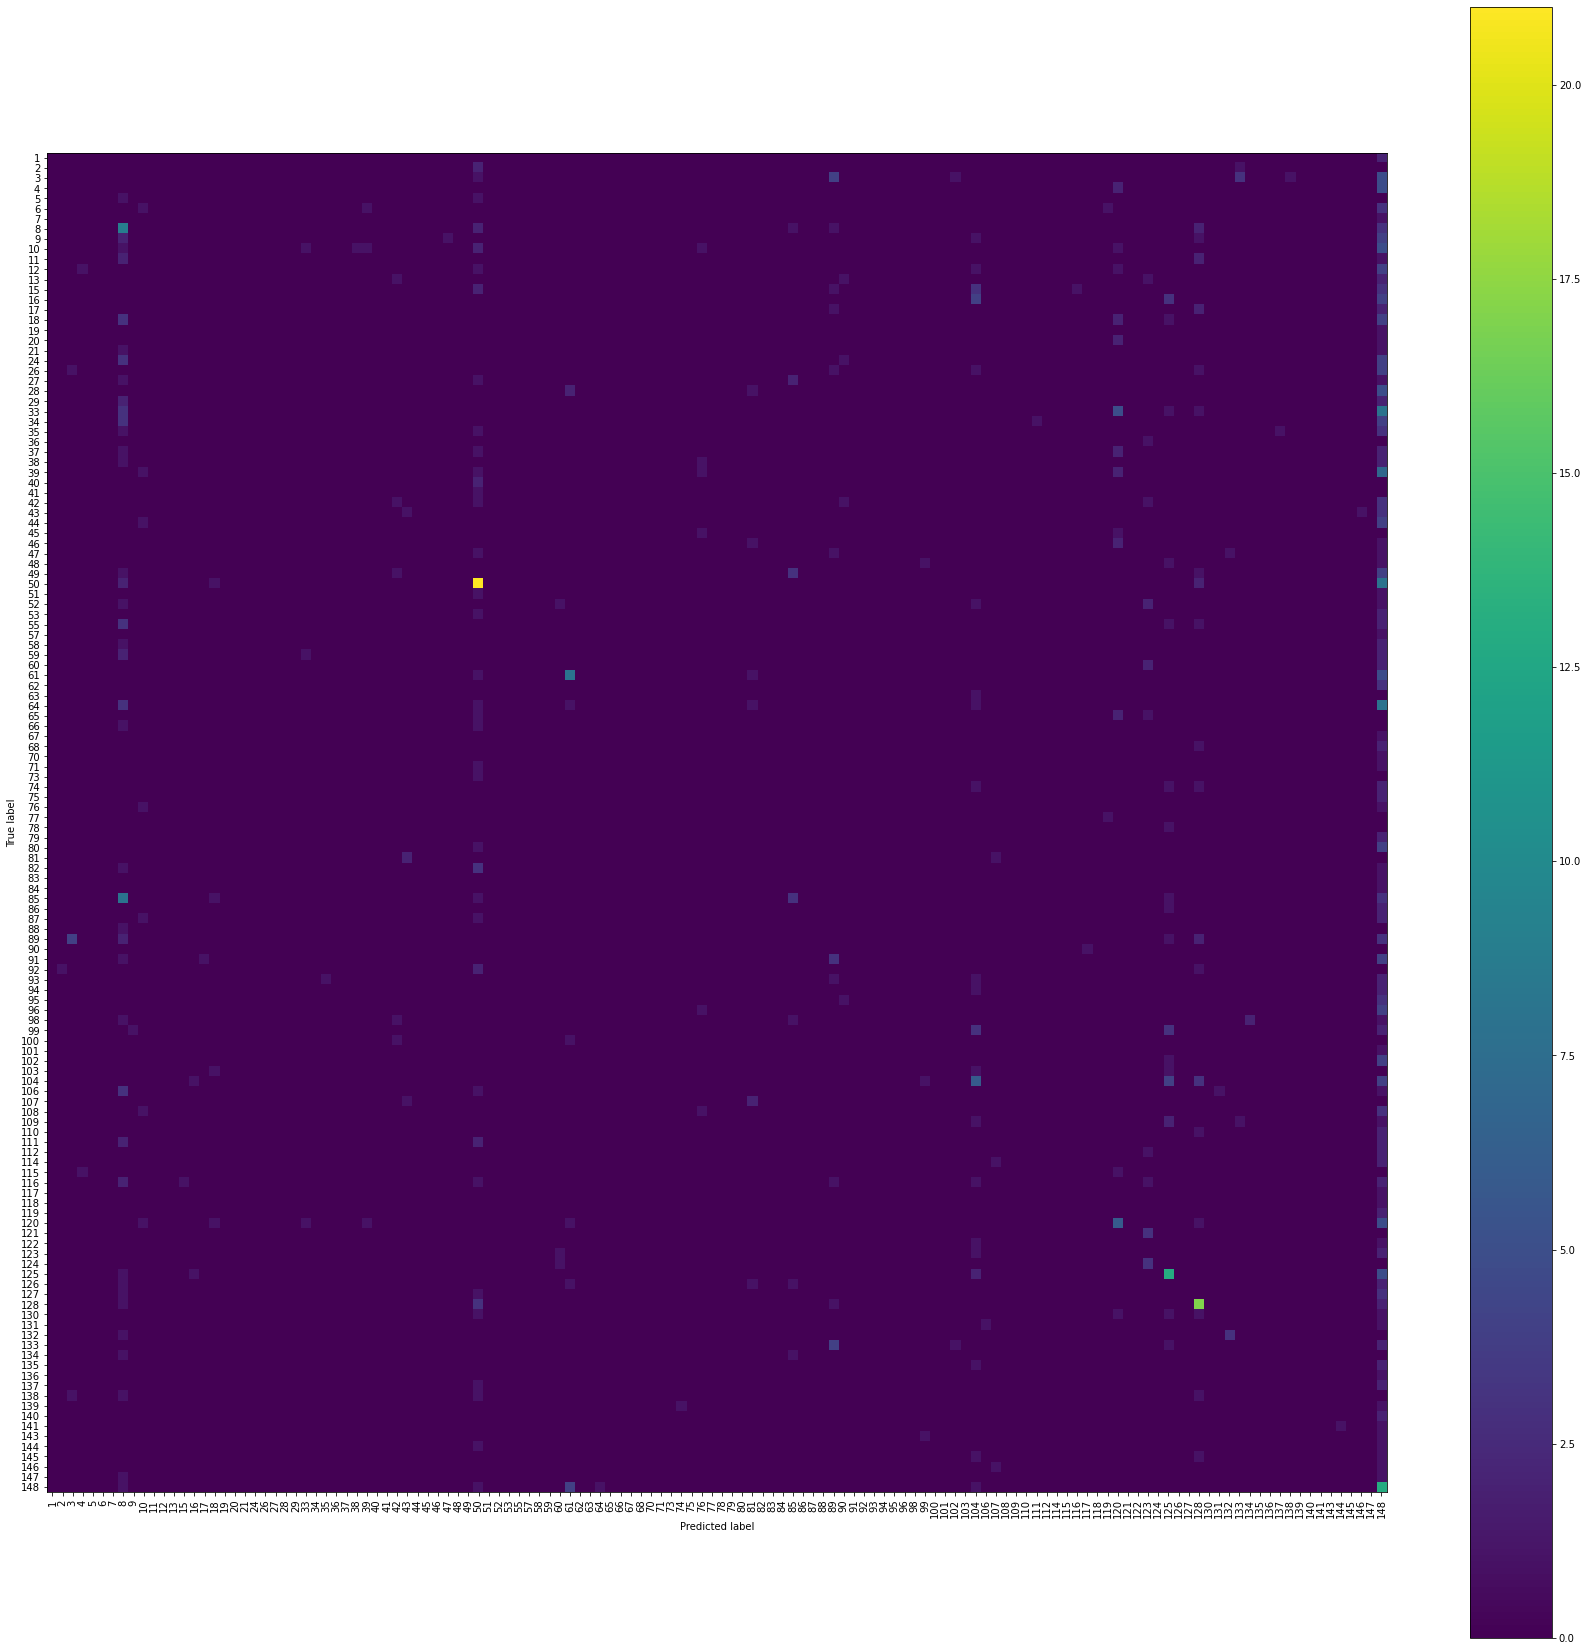

In [82]:
clf = RandomForestClassifier(n_estimators = 500, max_depth = 10)
fit_classifier(texts, labels, clf)

## Наблюдения

Интересно, то, что не смотря на низкую точность модели, на матрице неточностей мы видем уплотнотнение на некоторых столбцах (это ложные распознавания), посмотрим на эти кухни.

In [80]:
list(le.inverse_transform([8, 50, 148]))

['Категория:Американская кухня\n',
 'Категория:Итальянская кухня\n',
 'Категория:Японская кухня\n']

Не удивительно, что это самые разнообразные кухни в мире

## Попробуем CatBoost

Learning rate set to 0.083554
0:	learn: 4.8770174	total: 639ms	remaining: 10m 38s
1:	learn: 4.8093204	total: 1.11s	remaining: 9m 15s
2:	learn: 4.7297513	total: 1.66s	remaining: 9m 12s
3:	learn: 4.6775680	total: 2.17s	remaining: 9m
4:	learn: 4.6354338	total: 2.62s	remaining: 8m 40s
5:	learn: 4.5957644	total: 3.06s	remaining: 8m 27s
6:	learn: 4.5553505	total: 3.49s	remaining: 8m 15s
7:	learn: 4.5204765	total: 3.95s	remaining: 8m 9s
8:	learn: 4.4889604	total: 4.38s	remaining: 8m 2s
9:	learn: 4.4640552	total: 4.86s	remaining: 8m 1s
10:	learn: 4.4448768	total: 5.31s	remaining: 7m 57s
11:	learn: 4.4236301	total: 5.77s	remaining: 7m 55s
12:	learn: 4.4028266	total: 6.19s	remaining: 7m 49s
13:	learn: 4.3846050	total: 6.67s	remaining: 7m 49s
14:	learn: 4.3664796	total: 7.11s	remaining: 7m 46s
15:	learn: 4.3450027	total: 7.64s	remaining: 7m 50s
16:	learn: 4.3300938	total: 8.18s	remaining: 7m 52s
17:	learn: 4.3152670	total: 8.61s	remaining: 7m 49s
18:	learn: 4.2994591	total: 9.02s	remaining: 7m 45

157:	learn: 3.2962051	total: 1m 20s	remaining: 7m 7s
158:	learn: 3.2898198	total: 1m 20s	remaining: 7m 7s
159:	learn: 3.2844320	total: 1m 21s	remaining: 7m 6s
160:	learn: 3.2779435	total: 1m 21s	remaining: 7m 6s
161:	learn: 3.2769758	total: 1m 22s	remaining: 7m 5s
162:	learn: 3.2748337	total: 1m 23s	remaining: 7m 6s
163:	learn: 3.2691311	total: 1m 23s	remaining: 7m 6s
164:	learn: 3.2659104	total: 1m 24s	remaining: 7m 6s
165:	learn: 3.2582705	total: 1m 24s	remaining: 7m 6s
166:	learn: 3.2531564	total: 1m 25s	remaining: 7m 5s
167:	learn: 3.2513994	total: 1m 25s	remaining: 7m 4s
168:	learn: 3.2436795	total: 1m 26s	remaining: 7m 4s
169:	learn: 3.2399259	total: 1m 26s	remaining: 7m 3s
170:	learn: 3.2374397	total: 1m 27s	remaining: 7m 3s
171:	learn: 3.2319729	total: 1m 27s	remaining: 7m 2s
172:	learn: 3.2303543	total: 1m 28s	remaining: 7m 1s
173:	learn: 3.2238235	total: 1m 28s	remaining: 7m 1s
174:	learn: 3.2207832	total: 1m 29s	remaining: 7m
175:	learn: 3.2138722	total: 1m 29s	remaining: 6m

311:	learn: 2.7506894	total: 2m 38s	remaining: 5m 49s
312:	learn: 2.7486904	total: 2m 38s	remaining: 5m 48s
313:	learn: 2.7440488	total: 2m 39s	remaining: 5m 49s
314:	learn: 2.7432806	total: 2m 40s	remaining: 5m 49s
315:	learn: 2.7410098	total: 2m 41s	remaining: 5m 48s
316:	learn: 2.7365772	total: 2m 41s	remaining: 5m 48s
317:	learn: 2.7343094	total: 2m 42s	remaining: 5m 47s
318:	learn: 2.7328232	total: 2m 42s	remaining: 5m 47s
319:	learn: 2.7315171	total: 2m 43s	remaining: 5m 47s
320:	learn: 2.7293928	total: 2m 43s	remaining: 5m 46s
321:	learn: 2.7290413	total: 2m 44s	remaining: 5m 46s
322:	learn: 2.7240344	total: 2m 45s	remaining: 5m 46s
323:	learn: 2.7212572	total: 2m 45s	remaining: 5m 45s
324:	learn: 2.7202076	total: 2m 46s	remaining: 5m 44s
325:	learn: 2.7174992	total: 2m 46s	remaining: 5m 44s
326:	learn: 2.7155824	total: 2m 46s	remaining: 5m 43s
327:	learn: 2.7139473	total: 2m 47s	remaining: 5m 42s
328:	learn: 2.7126299	total: 2m 47s	remaining: 5m 42s
329:	learn: 2.7076984	total:

464:	learn: 2.4409591	total: 3m 53s	remaining: 4m 28s
465:	learn: 2.4384917	total: 3m 53s	remaining: 4m 27s
466:	learn: 2.4370711	total: 3m 54s	remaining: 4m 27s
467:	learn: 2.4351814	total: 3m 54s	remaining: 4m 26s
468:	learn: 2.4345252	total: 3m 55s	remaining: 4m 26s
469:	learn: 2.4344670	total: 3m 55s	remaining: 4m 25s
470:	learn: 2.4309459	total: 3m 55s	remaining: 4m 25s
471:	learn: 2.4303956	total: 3m 56s	remaining: 4m 24s
472:	learn: 2.4282871	total: 3m 56s	remaining: 4m 23s
473:	learn: 2.4267270	total: 3m 57s	remaining: 4m 23s
474:	learn: 2.4252561	total: 3m 57s	remaining: 4m 22s
475:	learn: 2.4243272	total: 3m 58s	remaining: 4m 22s
476:	learn: 2.4233566	total: 3m 58s	remaining: 4m 21s
477:	learn: 2.4228539	total: 3m 59s	remaining: 4m 21s
478:	learn: 2.4201215	total: 3m 59s	remaining: 4m 20s
479:	learn: 2.4192139	total: 3m 59s	remaining: 4m 19s
480:	learn: 2.4161379	total: 4m	remaining: 4m 19s
481:	learn: 2.4150650	total: 4m	remaining: 4m 18s
482:	learn: 2.4142690	total: 4m 1s	r

617:	learn: 2.2257812	total: 4m 58s	remaining: 3m 4s
618:	learn: 2.2257096	total: 4m 58s	remaining: 3m 4s
619:	learn: 2.2242142	total: 4m 59s	remaining: 3m 3s
620:	learn: 2.2215352	total: 4m 59s	remaining: 3m 2s
621:	learn: 2.2202052	total: 5m	remaining: 3m 2s
622:	learn: 2.2196147	total: 5m	remaining: 3m 1s
623:	learn: 2.2180056	total: 5m 1s	remaining: 3m 1s
624:	learn: 2.2172251	total: 5m 1s	remaining: 3m
625:	learn: 2.2161627	total: 5m 1s	remaining: 3m
626:	learn: 2.2145870	total: 5m 2s	remaining: 2m 59s
627:	learn: 2.2131564	total: 5m 2s	remaining: 2m 59s
628:	learn: 2.2123577	total: 5m 3s	remaining: 2m 58s
629:	learn: 2.2116369	total: 5m 3s	remaining: 2m 58s
630:	learn: 2.2107102	total: 5m 4s	remaining: 2m 57s
631:	learn: 2.2102922	total: 5m 4s	remaining: 2m 57s
632:	learn: 2.2092587	total: 5m 5s	remaining: 2m 56s
633:	learn: 2.2076485	total: 5m 5s	remaining: 2m 56s
634:	learn: 2.2055491	total: 5m 6s	remaining: 2m 56s
635:	learn: 2.2054892	total: 5m 6s	remaining: 2m 55s
636:	learn

771:	learn: 2.0561184	total: 6m 3s	remaining: 1m 47s
772:	learn: 2.0559429	total: 6m 4s	remaining: 1m 47s
773:	learn: 2.0546949	total: 6m 4s	remaining: 1m 46s
774:	learn: 2.0537982	total: 6m 5s	remaining: 1m 46s
775:	learn: 2.0531571	total: 6m 6s	remaining: 1m 45s
776:	learn: 2.0517839	total: 6m 6s	remaining: 1m 45s
777:	learn: 2.0512759	total: 6m 7s	remaining: 1m 44s
778:	learn: 2.0505567	total: 6m 7s	remaining: 1m 44s
779:	learn: 2.0496032	total: 6m 8s	remaining: 1m 43s
780:	learn: 2.0492566	total: 6m 8s	remaining: 1m 43s
781:	learn: 2.0491979	total: 6m 9s	remaining: 1m 42s
782:	learn: 2.0484625	total: 6m 9s	remaining: 1m 42s
783:	learn: 2.0478779	total: 6m 10s	remaining: 1m 41s
784:	learn: 2.0468012	total: 6m 10s	remaining: 1m 41s
785:	learn: 2.0463296	total: 6m 10s	remaining: 1m 41s
786:	learn: 2.0446174	total: 6m 11s	remaining: 1m 40s
787:	learn: 2.0433866	total: 6m 11s	remaining: 1m 40s
788:	learn: 2.0433541	total: 6m 12s	remaining: 1m 39s
789:	learn: 2.0422405	total: 6m 12s	rema

926:	learn: 1.9270702	total: 7m 14s	remaining: 34.2s
927:	learn: 1.9262856	total: 7m 15s	remaining: 33.8s
928:	learn: 1.9255030	total: 7m 15s	remaining: 33.3s
929:	learn: 1.9250305	total: 7m 16s	remaining: 32.8s
930:	learn: 1.9238429	total: 7m 16s	remaining: 32.4s
931:	learn: 1.9229469	total: 7m 17s	remaining: 31.9s
932:	learn: 1.9222960	total: 7m 17s	remaining: 31.4s
933:	learn: 1.9215616	total: 7m 17s	remaining: 30.9s
934:	learn: 1.9204486	total: 7m 18s	remaining: 30.5s
935:	learn: 1.9195549	total: 7m 18s	remaining: 30s
936:	learn: 1.9187263	total: 7m 19s	remaining: 29.5s
937:	learn: 1.9178165	total: 7m 19s	remaining: 29.1s
938:	learn: 1.9166510	total: 7m 20s	remaining: 28.6s
939:	learn: 1.9158064	total: 7m 20s	remaining: 28.1s
940:	learn: 1.9148997	total: 7m 21s	remaining: 27.6s
941:	learn: 1.9135819	total: 7m 21s	remaining: 27.2s
942:	learn: 1.9132213	total: 7m 21s	remaining: 26.7s
943:	learn: 1.9123183	total: 7m 22s	remaining: 26.2s
944:	learn: 1.9114450	total: 7m 22s	remaining: 2

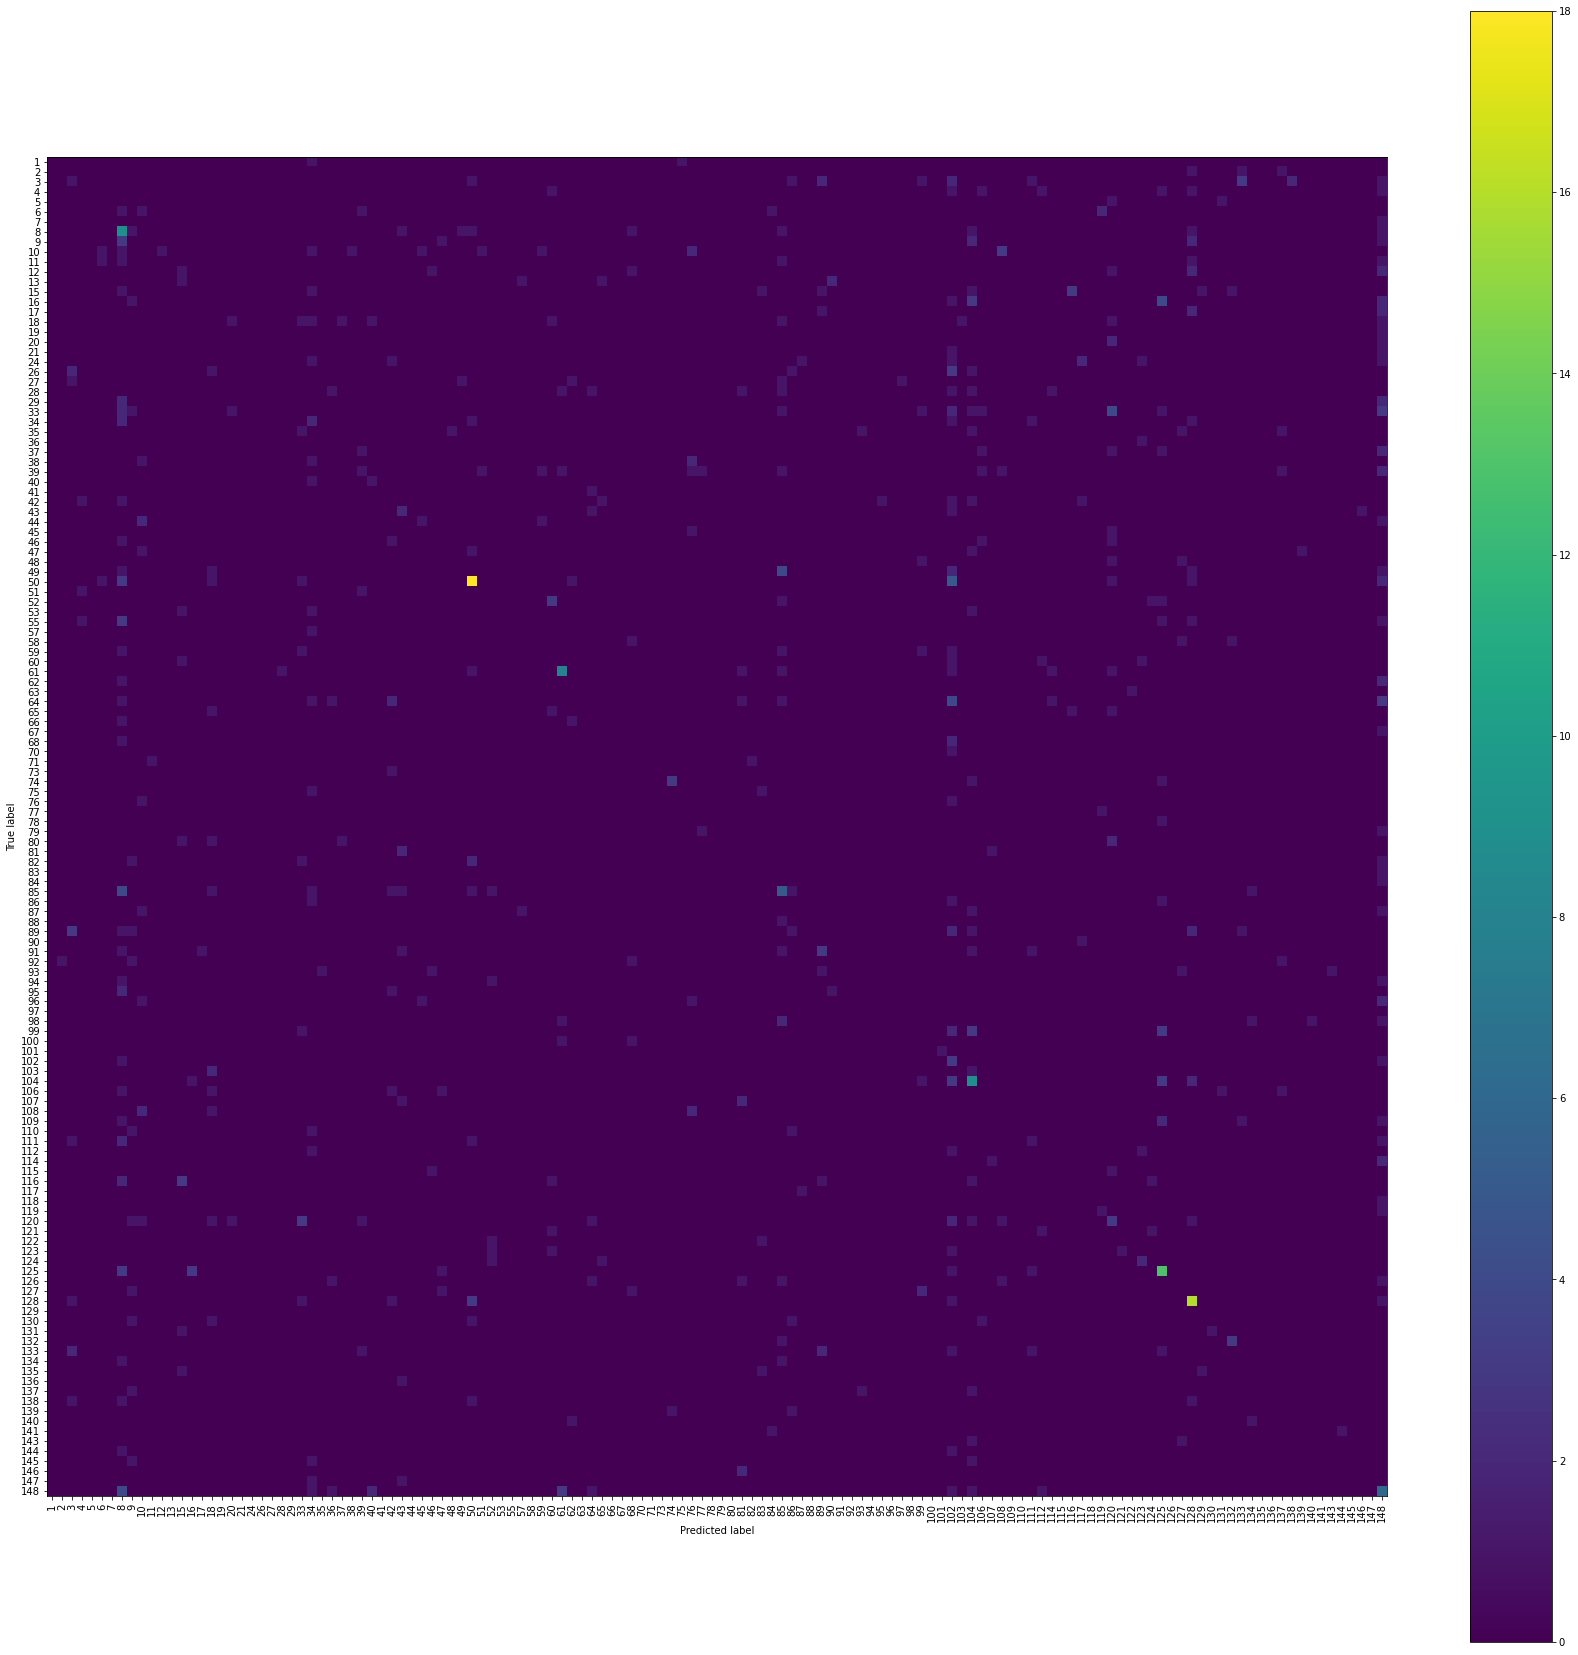

In [84]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
fit_classifier(texts, labels, clf)